In [1]:
import torch
from torchvision import transforms
from torchvision.datasets.utils import download_and_extract_archive
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from pathlib import Path

# Set the path to store the Tiny ImageNet dataset
data_root = Path('/workspace/kjh/Kraken-Trainer/data')
data_dir = data_root / 'tiny-imagenet-200'

# Define the URL and filename of the dataset
url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
filename = 'tiny-imagenet-200.zip'


In [2]:
import PIL.Image as Image
import numpy as np
import os

from collections import defaultdict
from torch.utils.data import Dataset

from tqdm.autonotebook import tqdm

dir_structure_help = r"""
TinyImageNetPath
├── test
│   └── images
│       ├── test_0.JPEG
│       ├── t...
│       └── ...
├── train
│   ├── n01443537
│   │   ├── images
│   │   │   ├── n01443537_0.JPEG
│   │   │   ├── n...
│   │   │   └── ...
│   │   └── n01443537_boxes.txt
│   ├── n01629819
│   │   ├── images
│   │   │   ├── n01629819_0.JPEG
│   │   │   ├── n...
│   │   │   └── ...
│   │   └── n01629819_boxes.txt
│   ├── n...
│   │   ├── images
│   │   │   ├── ...
│   │   │   └── ...
├── val
│   ├── images
│   │   ├── val_0.JPEG
│   │   ├── v...
│   │   └── ...
│   └── val_annotations.txt
├── wnids.txt
└── words.txt
"""

def download_and_unzip(URL, root):
    filename = URL.split('/')[-1]
    download_and_extract_archive(url, download_root=data_dir, filename=filename)

def _add_channels(img, total_channels=3):
    while len(img.shape) < 3:  # third axis is the channels
        img = np.expand_dims(img, axis=-1)
    while (img.shape[-1]) < 3:
        img = np.concatenate([img, img[:, :, -1:]], axis=-1)
    return img

class TinyImageNetPaths:
    def __init__(self, root, download=False):
        if download:
            download_and_unzip('http://cs231n.stanford.edu/tiny-imagenet-200.zip', root)
        train_path = Path(root) / 'train'
        val_path = Path(root) / 'val'
        test_path = Path(root) / 'test'

        wnids_path = Path(root) / 'wnids.txt'
        words_path = Path(root) / 'words.txt'

        self._make_paths(train_path, val_path, test_path, wnids_path, words_path)

    def _make_paths(self, train_path, val_path, test_path, wnids_path, words_path):
        self.ids = []
        with open(wnids_path, 'r') as idf:
            for nid in idf:
                nid = nid.strip()
                self.ids.append(nid)
        self.nid_to_words = defaultdict(list)
        with open(words_path, 'r') as wf:
            for line in wf:
                nid, labels = line.split('\t')
                labels = list(map(lambda x: x.strip(), labels.split(',')))
                self.nid_to_words[nid].extend(labels)

        self.paths = {
            'train': [],  # [img_path, id, nid, box]
            'val': [],  # [img_path, id, nid, box]
            'test': []  # img_path
        }

        # Get the test paths
        self.paths['test'] = list(test_path.glob('*'))

        # Get the validation paths and labels
        with open(val_path / 'val_annotations.txt') as valf:
            for line in valf:
                fname, nid, x0, y0, x1, y1 = line.split()
                fname = val_path / 'images' / fname
                bbox = int(x0), int(y0), int(x1), int(y1)
                label_id = self.ids.index(nid)
                self.paths['val'].append((str(fname), label_id, nid, bbox))

        # Get the training paths
        train_nids = [entry.name for entry in train_path.iterdir() if entry.is_dir()]
        for nid in train_nids:
            anno_path = train_path / nid / (nid + '_boxes.txt')
            imgs_path = train_path / nid / 'images'
            label_id = self.ids.index(nid)
            with open(anno_path, 'r') as annof:
                for line in annof:
                    fname, x0, y0, x1, y1 = line.split()
                    fname = imgs_path / fname
                    bbox = int(x0), int(y0), int(x1), int(y1)
                    self.paths['train'].append((str(fname), label_id, nid, bbox))

class TinyImageNetDataset(Dataset):
    def __init__(self, root, mode='train', download=False, transform=None):
        tinp = TinyImageNetPaths(root, download)
        self.mode = mode
        self.fname_idx = 0
        self.label_idx = 1
        self.transform = transform

        self.IMAGE_SHAPE = (64, 64, 3)

        self.img_data = []
        self.label_data = []

        self.samples = tinp.paths[mode]
        self.samples_num = len(self.samples)


    def __len__(self):
        return self.samples_num

    def __getitem__(self, idx):
        s = self.samples[idx]
        img = Image.open(s[0])
        img = _add_channels(np.array(img))
        lbl = None if self.mode == 'test' else s[1] # test data has no label

        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(lbl)


/tmp/ipykernel_25474/2884915111.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
# Define the transform to apply to the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    # transforms.CenterCrop(224),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def collate_fn(batch):
    images = []
    labels = []

    for img, label in batch:
        images.append(img)
        labels.append(label)

    return torch.stack(images), torch.stack(labels)


# Load the train and validation datasets
train_dataset = TinyImageNetDataset(root = data_dir, mode = 'train', transform=transform)
val_dataset = TinyImageNetDataset(root = data_dir, mode = 'val', transform=transform)
test_dataset = TinyImageNetDataset(root = data_dir, mode = 'test', transform=transform)

# Create data loaders for training and validation
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

/home/kjh/.conda/envs/test/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


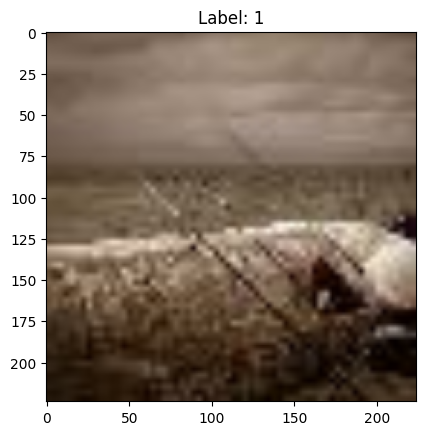

In [4]:
import matplotlib.pyplot as plt

# Plot a sample image
def plot_image(image, label):
    fig, ax = plt.subplots()
    image = image.permute(1, 2, 0)
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    fig.show()

# Get a sample image from the train dataset
sample_image, label = val_dataset[1]
plot_image(sample_image, label)

In [5]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm


# Training loop
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    accuracy = 100 * correct / total
    loss = running_loss / len(dataloader)

    return loss, accuracy

# Validation loop
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

    accuracy = 100 * correct / total
    loss = running_loss / len(dataloader)

    return loss, accuracy

# Test loop
def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

    accuracy = 100 * correct / total
    loss = running_loss / len(dataloader)

    return loss, accuracy

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = 200
model = models.resnet50(weights = models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = test(model, val_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}  Accuracy: {test_accuracy:.2f}%")
print(model)

  0%|          | 0/313 [00:00<?, ?it/s]/home/kjh/.conda/envs/test/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/kjh/.conda/envs/test/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will

Test Loss: 5.3120  Accuracy: 0.36%
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 2

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create a ResNet-50 model and move it to the device
model = models.resnet50(pretrained=True)
num_classes = 200
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Define the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Training and evaluation
num_epochs = 10
writer = SummaryWriter()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    print(f"Train Loss: {train_loss:.4f}  Accuracy: {train_accuracy:.2f}%")

    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}  Accuracy: {val_accuracy:.2f}%")

    scheduler.step()
    
    # Log metrics to TensorBoard
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)

    scheduler.step()

# Testing the model
test_loss, test_accuracy = test(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}  Accuracy: {test_accuracy:.2f}%")

# Log metrics to TensorBoard
writer.add_scalar('Loss/Test', test_loss)
writer.add_scalar('Accuracy/Test', test_accuracy)

# Close the SummaryWriter
writer.close()

# Testing the model
test_loss, test_accuracy = test(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}  Accuracy: {test_accuracy:.2f}%")

/home/kjh/.conda/envs/test/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kjh/.conda/envs/test/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------


/home/kjh/.conda/envs/test/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/kjh/.conda/envs/test/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Train Loss: 1.8722  Accuracy: 60.78%


/home/kjh/.conda/envs/test/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/kjh/.conda/envs/test/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 

Validation Loss: 0.9422  Accuracy: 75.39%
Epoch 2/10
----------


/home/kjh/.conda/envs/test/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/kjh/.conda/envs/test/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in 